# Loading libraries and data

### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing data

In [ ]:
savePath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/'
# savePath = 'G:/Il mio Drive/Secondo Anno Magistrale/Machine Learning/'
def loadData(sPath):
  images = np.load(savePath+'images.npy')
  labels = np.load(savePath+'labels.npy')
  return(images, labels)

X, y = loadData(savePath)

From string response to numeric

In [ ]:
labEnc = LabelEncoder()
y_num = labEnc.fit_transform(y) # from string to numeric vector
label_dict = {label: i for i, label in enumerate(labEnc.classes_)}
print(label_dict)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


### Creating class ImageDataset

The ImageDataset class aims to extend the Dataset class from torch.utils.data.Dataset in order to create a dataset containing images and labels that can be used in a PyTorch CNN.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = np.expand_dims(image, axis=0)
        return image, label

Creating training validation and test data 70/15/15%

In [ ]:
Xtrn, Xvt, ytrn, yvt = train_test_split(X, y_num, test_size = .3, random_state = 1998)
Xvld, Xtst, yvld, ytst = train_test_split(Xvt, yvt, test_size = .5, random_state = 1998)

data_train = ImageDataset(Xtrn, ytrn)
data_valid = ImageDataset(Xvld, yvld)
data_test = ImageDataset(Xtst, ytst)

print("n. train Images, dimension", data_train.images.shape)
print("n train Labels", data_train.labels.shape)

n. train Images, dimension (20300, 50, 50)
n train Labels (20300,)


In [ ]:
Counter(ytrn)

Counter({24: 684,
         3: 691,
         19: 700,
         4: 672,
         14: 693,
         13: 699,
         28: 689,
         2: 704,
         26: 675,
         6: 691,
         25: 695,
         1: 705,
         11: 716,
         23: 715,
         21: 711,
         18: 703,
         10: 694,
         7: 694,
         9: 692,
         20: 698,
         0: 691,
         16: 726,
         8: 713,
         17: 704,
         15: 697,
         27: 720,
         5: 717,
         22: 709,
         12: 702})

Defining batch size and loading data

In [ ]:
bs = 64
train = DataLoader(data_train, batch_size = bs, shuffle = True)
validation = DataLoader(data_valid, batch_size = bs, shuffle = False)
test = DataLoader(data_test, batch_size = bs, shuffle = False)

Running code on GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ConvNet

Defining the convNet

In [ ]:
class convNet1(nn.Module):
    def __init__(self):
        super(convNet1, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5) # out_channels = number of conv Filter. Kernel size: size of the filter. In_channels = 1 because BW images.
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # stride is how many pixel the filter move at every detection on the image
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5) 
        
        self.fc1 = nn.Linear(32 * 9 * 9, 120) # flattening
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 29) 
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

net = convNet1()
net.to(device)

convNet1(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2592, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=29, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Summarizing the structure of the net:

In [ ]:
summary(net, input_size = (1, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             416
         MaxPool2d-2           [-1, 16, 23, 23]               0
            Conv2d-3           [-1, 32, 19, 19]          12,832
         MaxPool2d-4             [-1, 32, 9, 9]               0
            Linear-5                  [-1, 120]         311,160
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 29]           2,465
Total params: 337,037
Trainable params: 337,037
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.43
Params size (MB): 1.29
Estimated Total Size (MB): 1.73
----------------------------------------------------------------


<ipython-input-9-a3dad9871cf2>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


Training the net:

In [ ]:
learning_rate = 0.001
num_epochs = 100 

loss_train = torch.empty(num_epochs)
loss_val = torch.empty(num_epochs)
acc_train = torch.empty(num_epochs)
acc_val = torch.empty(num_epochs)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, 
                              verbose=True, threshold=0.001) # it reduces the LR when you are next to a maximum (plateau)
early_stopping_rounds = 5  # if loss doesn't decrease for a number of epochs specified here, breaks the cycle
early_stopping_threshold = 0.0001  # loss threshold

best_loss = float('inf')
num_rounds_no_improve = 0

for epoch in tqdm(range(num_epochs)):
   
    total_acc_train = 0
    total_loss_train = 0
    
    for i, data in enumerate(train, 0):
        # load data
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device)

        # gradient equal to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_acc_train += (predicted == labels).sum().item()
        
    total_acc_val = 0
    total_loss_val = 0
    
    with torch.no_grad(): 
        # loss and accuracy on validation set
        for data in validation:
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device)
            outputs = net(images)
            batch_loss = criterion(outputs, labels)
            total_loss_val += batch_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            acc = (predicted == labels).sum().item()
            total_acc_val += acc
    scheduler.step(total_loss_val/ len(data_valid))    

    if epoch > 0:
        diff_loss = abs(loss_val[epoch-1] - total_loss_val / len(data_valid))
    else:
        diff_loss = float('inf')
        
    if diff_loss < early_stopping_threshold:
        num_rounds_no_improve += 1
    else:
        num_rounds_no_improve = 0
    
    # early stopping implementation
    if num_rounds_no_improve == early_stopping_rounds:
        print(f'Early stopping at epoch {epoch}')
        break

    print(
                f'Epoch: {epoch + 1} | Train Loss: {total_loss_train / len(data_train): .3f} \
                | Train Accuracy: {total_acc_train / len(data_train): .3f} \
                | Val Loss: {total_loss_val / len(data_valid): .3f} \
                | Val Accuracy: {total_acc_val / len(data_valid): .3f}')
    loss_train[epoch] = total_loss_train / len(data_train)
    loss_val[epoch] = total_loss_val / len(data_valid)
    acc_train[epoch] = total_acc_train / len(data_train)
    acc_val[epoch] = total_acc_val / len(data_valid)

    

  1%|          | 1/100 [00:03<05:25,  3.29s/it]

Epoch: 1 | Train Loss:  0.030                 | Train Accuracy:  0.441                 | Val Loss:  0.014                 | Val Accuracy:  0.716


  2%|▏         | 2/100 [00:04<03:37,  2.22s/it]

Epoch: 2 | Train Loss:  0.010                 | Train Accuracy:  0.788                 | Val Loss:  0.009                 | Val Accuracy:  0.812


  3%|▎         | 3/100 [00:06<03:01,  1.87s/it]

Epoch: 3 | Train Loss:  0.006                 | Train Accuracy:  0.879                 | Val Loss:  0.006                 | Val Accuracy:  0.881


  4%|▍         | 4/100 [00:07<02:43,  1.71s/it]

Epoch: 4 | Train Loss:  0.004                 | Train Accuracy:  0.913                 | Val Loss:  0.006                 | Val Accuracy:  0.889


  5%|▌         | 5/100 [00:09<02:33,  1.61s/it]

Epoch: 5 | Train Loss:  0.003                 | Train Accuracy:  0.937                 | Val Loss:  0.003                 | Val Accuracy:  0.931


  6%|▌         | 6/100 [00:10<02:26,  1.56s/it]

Epoch: 6 | Train Loss:  0.002                 | Train Accuracy:  0.957                 | Val Loss:  0.004                 | Val Accuracy:  0.922


  7%|▋         | 7/100 [00:12<02:21,  1.52s/it]

Epoch: 7 | Train Loss:  0.003                 | Train Accuracy:  0.943                 | Val Loss:  0.005                 | Val Accuracy:  0.913


  8%|▊         | 8/100 [00:13<02:29,  1.62s/it]

Epoch: 8 | Train Loss:  0.003                 | Train Accuracy:  0.951                 | Val Loss:  0.005                 | Val Accuracy:  0.917


  9%|▉         | 9/100 [00:15<02:36,  1.72s/it]

Epoch: 9 | Train Loss:  0.002                 | Train Accuracy:  0.958                 | Val Loss:  0.004                 | Val Accuracy:  0.922


 10%|█         | 10/100 [00:17<02:27,  1.64s/it]

Epoch: 10 | Train Loss:  0.002                 | Train Accuracy:  0.965                 | Val Loss:  0.004                 | Val Accuracy:  0.926


 11%|█         | 11/100 [00:18<02:20,  1.58s/it]

Epoch: 11 | Train Loss:  0.002                 | Train Accuracy:  0.964                 | Val Loss:  0.004                 | Val Accuracy:  0.939


 12%|█▏        | 12/100 [00:20<02:15,  1.54s/it]

Epoch: 12 | Train Loss:  0.001                 | Train Accuracy:  0.976                 | Val Loss:  0.005                 | Val Accuracy:  0.920


 13%|█▎        | 13/100 [00:21<02:12,  1.53s/it]

Epoch: 13 | Train Loss:  0.002                 | Train Accuracy:  0.968                 | Val Loss:  0.004                 | Val Accuracy:  0.945


 14%|█▍        | 14/100 [00:23<02:09,  1.50s/it]

Epoch: 14 | Train Loss:  0.001                 | Train Accuracy:  0.977                 | Val Loss:  0.004                 | Val Accuracy:  0.943


 15%|█▌        | 15/100 [00:24<02:06,  1.49s/it]

Epoch: 15 | Train Loss:  0.001                 | Train Accuracy:  0.974                 | Val Loss:  0.005                 | Val Accuracy:  0.924


 16%|█▌        | 16/100 [00:26<02:08,  1.53s/it]

Epoch: 16 | Train Loss:  0.001                 | Train Accuracy:  0.977                 | Val Loss:  0.003                 | Val Accuracy:  0.948


 17%|█▋        | 17/100 [00:28<02:17,  1.66s/it]

Epoch: 17 | Train Loss:  0.001                 | Train Accuracy:  0.974                 | Val Loss:  0.005                 | Val Accuracy:  0.940


 18%|█▊        | 18/100 [00:29<02:16,  1.67s/it]

Epoch: 18 | Train Loss:  0.002                 | Train Accuracy:  0.967                 | Val Loss:  0.005                 | Val Accuracy:  0.933


 19%|█▉        | 19/100 [00:31<02:09,  1.60s/it]

Epoch: 19 | Train Loss:  0.002                 | Train Accuracy:  0.971                 | Val Loss:  0.005                 | Val Accuracy:  0.939


 20%|██        | 20/100 [00:32<02:05,  1.56s/it]

Epoch: 20 | Train Loss:  0.001                 | Train Accuracy:  0.982                 | Val Loss:  0.004                 | Val Accuracy:  0.951


 21%|██        | 21/100 [00:34<02:00,  1.53s/it]

Epoch: 21 | Train Loss:  0.001                 | Train Accuracy:  0.984                 | Val Loss:  0.005                 | Val Accuracy:  0.936


 22%|██▏       | 22/100 [00:35<01:57,  1.50s/it]

Epoch: 22 | Train Loss:  0.002                 | Train Accuracy:  0.976                 | Val Loss:  0.004                 | Val Accuracy:  0.939


 23%|██▎       | 23/100 [00:37<01:55,  1.50s/it]

Epoch: 23 | Train Loss:  0.001                 | Train Accuracy:  0.985                 | Val Loss:  0.003                 | Val Accuracy:  0.954


 24%|██▍       | 24/100 [00:38<01:53,  1.49s/it]

Epoch: 24 | Train Loss:  0.001                 | Train Accuracy:  0.987                 | Val Loss:  0.004                 | Val Accuracy:  0.945


 25%|██▌       | 25/100 [00:40<01:58,  1.58s/it]

Epoch: 25 | Train Loss:  0.001                 | Train Accuracy:  0.988                 | Val Loss:  0.005                 | Val Accuracy:  0.943


 26%|██▌       | 26/100 [00:42<02:04,  1.68s/it]

Epoch: 26 | Train Loss:  0.001                 | Train Accuracy:  0.977                 | Val Loss:  0.006                 | Val Accuracy:  0.927


 27%|██▋       | 27/100 [00:43<01:59,  1.64s/it]

Epoch: 27 | Train Loss:  0.001                 | Train Accuracy:  0.976                 | Val Loss:  0.008                 | Val Accuracy:  0.921


 28%|██▊       | 28/100 [00:45<01:54,  1.59s/it]

Epoch: 28 | Train Loss:  0.002                 | Train Accuracy:  0.975                 | Val Loss:  0.007                 | Val Accuracy:  0.937


 29%|██▉       | 29/100 [00:47<01:57,  1.65s/it]

Epoch: 29 | Train Loss:  0.001                 | Train Accuracy:  0.978                 | Val Loss:  0.005                 | Val Accuracy:  0.949


 30%|███       | 30/100 [00:48<01:50,  1.58s/it]

Epoch: 30 | Train Loss:  0.001                 | Train Accuracy:  0.987                 | Val Loss:  0.005                 | Val Accuracy:  0.947


 31%|███       | 31/100 [00:49<01:46,  1.55s/it]

Epoch: 31 | Train Loss:  0.001                 | Train Accuracy:  0.984                 | Val Loss:  0.006                 | Val Accuracy:  0.940


 32%|███▏      | 32/100 [00:51<01:42,  1.51s/it]

Epoch: 32 | Train Loss:  0.001                 | Train Accuracy:  0.986                 | Val Loss:  0.004                 | Val Accuracy:  0.954


 33%|███▎      | 33/100 [00:52<01:41,  1.51s/it]

Epoch: 33 | Train Loss:  0.001                 | Train Accuracy:  0.991                 | Val Loss:  0.004                 | Val Accuracy:  0.958


 34%|███▍      | 34/100 [00:54<01:47,  1.62s/it]

Epoch 00034: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 34 | Train Loss:  0.001                 | Train Accuracy:  0.984                 | Val Loss:  0.006                 | Val Accuracy:  0.936


 35%|███▌      | 35/100 [00:56<01:48,  1.67s/it]

Epoch: 35 | Train Loss:  0.000                 | Train Accuracy:  0.996                 | Val Loss:  0.003                 | Val Accuracy:  0.963


 36%|███▌      | 36/100 [00:58<01:43,  1.62s/it]

Epoch: 36 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.003                 | Val Accuracy:  0.965


 37%|███▋      | 37/100 [00:59<01:39,  1.57s/it]

Epoch: 37 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.003                 | Val Accuracy:  0.967


 38%|███▊      | 38/100 [01:01<01:35,  1.54s/it]

Epoch: 38 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.003                 | Val Accuracy:  0.967


 39%|███▉      | 39/100 [01:02<01:32,  1.52s/it]

Epoch: 39 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.003                 | Val Accuracy:  0.968


 40%|████      | 40/100 [01:04<01:35,  1.60s/it]

Epoch: 40 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.003                 | Val Accuracy:  0.967


 40%|████      | 40/100 [01:06<01:39,  1.65s/it]

Early stopping at epoch 40


In [ ]:
savePath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello1/convNet1.pth'
torch.save(net, savePath)

In [ ]:
saveTensorPath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello1/'+'loss1Train.pth'
torch.save(loss_train, saveTensorPath)
saveTensorPath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello1/'+'loss1Val.pth'
torch.save(loss_val, saveTensorPath)
saveTensorPath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello1/'+'acc1Train.pth'
torch.save(acc_train, saveTensorPath)
saveTensorPath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello1/'+'acc1Val.pth'
torch.save(acc_val, saveTensorPath)

Accuracy and loss per epochs:

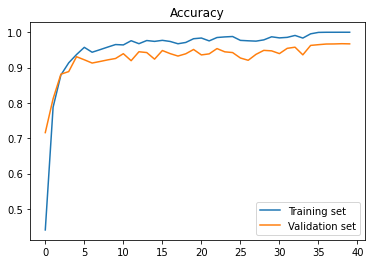

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(acc_train[0:epoch], label='Training set')
ax.plot(acc_val[0:epoch], label='Validation set')
ax.legend()
ax.set_title('Accuracy')
plt.show()

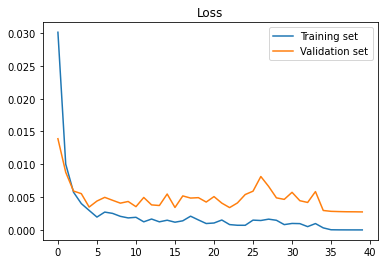

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_train[0:epoch], label = 'Training set')
ax.plot(loss_val[0:epoch], label = 'Validation set')
ax.legend()
ax.set_title('Loss')
plt.show()

Confusion matrix:

Accuracy on test images: 96 %


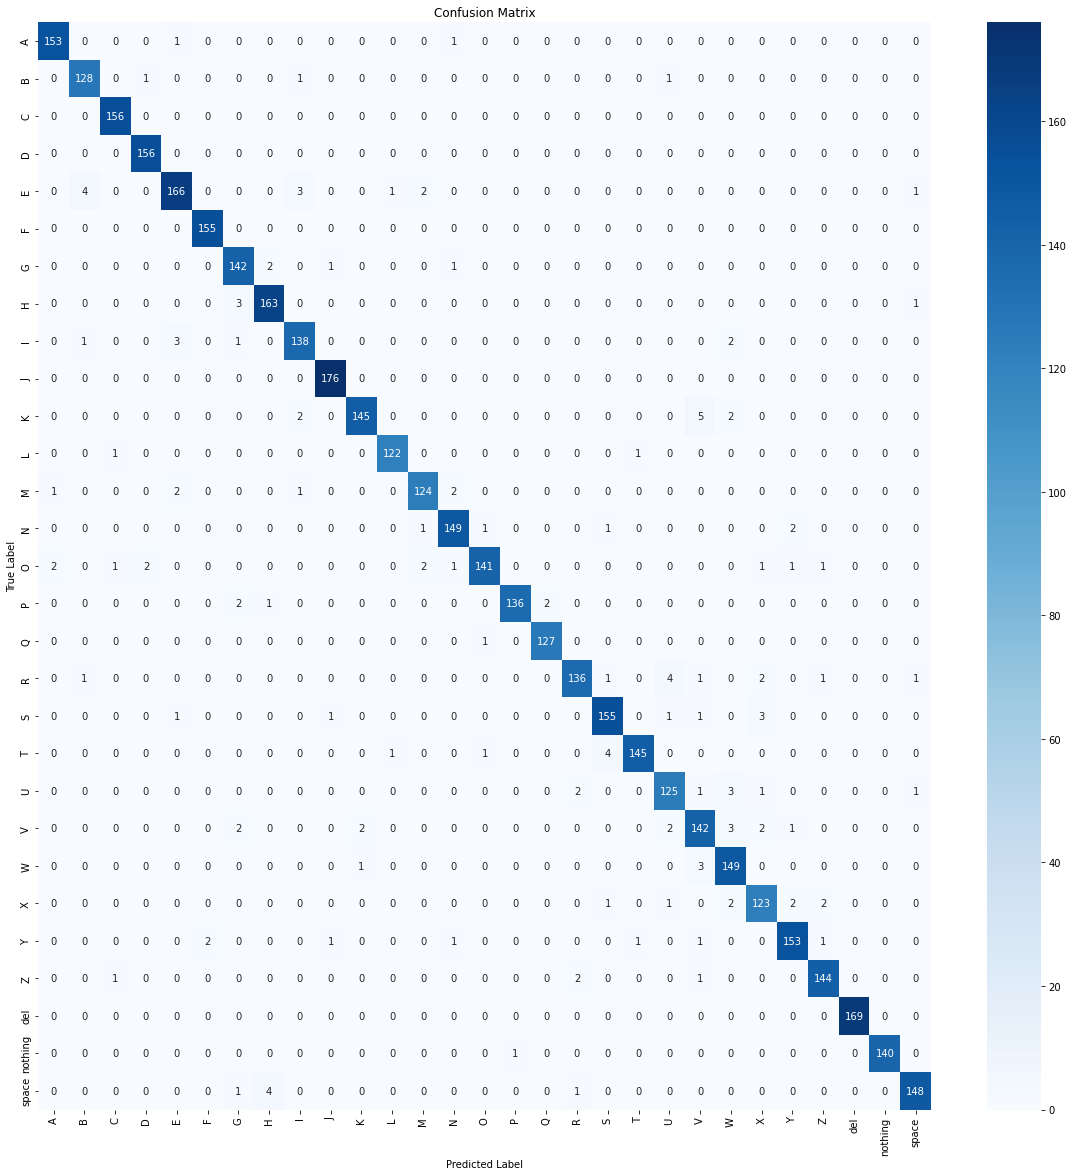

In [ ]:
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in test:
        images, labels = data
        images = images.to(device).float()
        labels = labels.to(device).float()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        correct += (predicted == labels).sum().item()
        
        y_true += labels.cpu().numpy().astype(int).tolist()
        y_pred += predicted.cpu().numpy().tolist()
        
print('Accuracy on test images: %d %%' % (100 * correct / len(ytst)))

# displaying conf matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_matrix, annot=True, xticklabels = label_dict.keys(), yticklabels = label_dict.keys(), cmap="Blues", fmt="d", ax=ax)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Example of classification of the first 9 images in the test set:

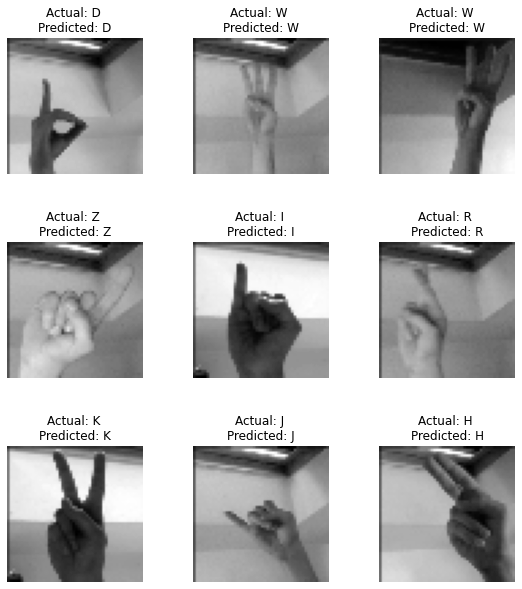

In [ ]:
def get_key_by_value(d, value): # returns the letter from the numeric label
    for k, v in d.items():
        if v == value:
            return k
    return None

with torch.no_grad():
    for data in test:
        images, labels = data
        images = images.to(device).float()
        labels = labels.to(device).float()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        break # takes only the classification for the first batch of 64 images
        
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace = 0)

# grid of subplots
k = 0
for i in range(3):
  for j in range(3):
    axs[i,j].imshow(Xtst[k], cmap = "gray")
    axs[i,j].set_title("Actual: "+get_key_by_value(label_dict, ytst[k])+" \nPredicted: "+get_key_by_value(label_dict, predicted[k].tolist()))
    axs[i,j].set_axis_off()
    k += 1

plt.show()